# Instruction-Level Workload Analysis

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from collections import defaultdict
import seaborn as sns

In [9]:

# === Common Variables ===

# List of instruction categories in the order used in the original code
CATEGORIES = ['Branches', 'Loads', 'Stores', 'I-types', 'R-types', 'Shifts and SLTs', 'Jumps']

# Consistent color palette for instruction categories
CATEGORY_COLORS = ['#92c6ff', '#97f0aa', '#f4b400', '#d291bc', '#ff4500', '#764428', '#ff55a3']

# Color palette for core types
CORE_COLORS = ['#4c72b0', '#dd8452', '#55a868']

# Duty cycle thresholds for runtime plot
DUTY_CYCLE_THRESHOLDS = {
    "1 ms": 1e-3,
    "1 s": 1,
    "1 min": 60,
    "1 hr": 3600,
    "1 day": 86400,
    "1 week": 604800,
    "1 month": 2592000
}

# Cycles per instruction for each core type
CYCLES_PER_INSTRUCTION_BY_CORE = {
    "HERV":{
        'Others': 4+3+4+3,
        'I-types': 4+3,
        'Loads': 4+3+4+3+70,
        'R-types': 4+3,
        'Stores': 4+3+4+3+35,
        'Branches': 4+3+4+3,
        'Shifts and SLTs': 4+3+4+3,
        'Jumps': 4+3
    },
    "QERV":{
        'Others': 8+3+8+3,
        'I-types': 8+3,
        'Loads': 8+3+8+3+70,
        'R-types': 8+3,
        'Stores': 8+3+8+3+35,
        'Branches': 8+3+8+3,
        'Shifts and SLTs': 8+3+8+3,
        'Jumps': 8+3
    },
    "SERV":{
        'Others': 32+3+32+3,
        'I-types': 32+3,
        'Loads': 32+3+32+3+70,
        'R-types': 32+3,
        'Stores': 32+3+32+3+35,
        'Branches': 32+3+32+3,
        'Shifts and SLTs': 32+3+32+3,
        'Jumps': 32+3
    }
}

In [10]:

# Read the instruction counts CSV
csv_path = "instr-counts.csv"
df = pd.read_csv(csv_path)

In [22]:
# Set common figure text sizing for consistency
TEXT_SIZE = 19
plt.rcParams.update({
    "axes.titlesize": TEXT_SIZE,
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TEXT_SIZE-2,
    "ytick.labelsize": TEXT_SIZE-2,
    "legend.fontsize": TEXT_SIZE,
    "figure.titlesize": TEXT_SIZE
})


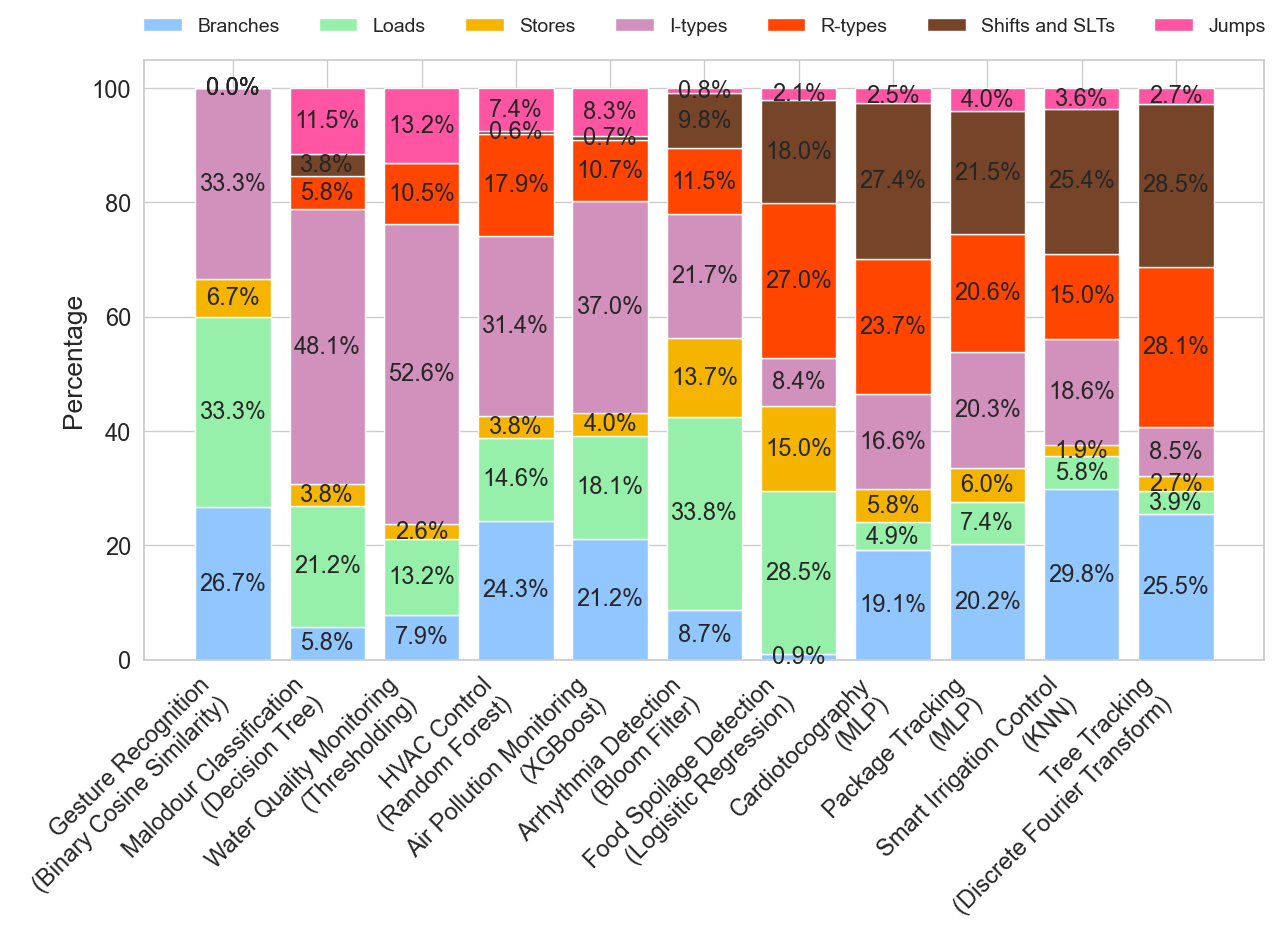

In [23]:

# Clean up workload names for plotting
def clean_workload_name(name):
    # Remove leading numbers and dots, e.g., "01. Gesture Recognition" -> "Gesture Recognition"
    return re.sub(r'^\d+\.\s*', '', name)

# Prepare data structures
instruction_data = defaultdict(lambda: defaultdict(int))
total_instructions_data = {}
workload_names = []

for idx, row in df.iterrows():
    workload = row['Workload']
    kernel = row['Kernel']
    # Combine for uniqueness if needed
    workload_label = f"{workload}\n({kernel})"
    workload_names.append(workload_label)
    total_instructions = row['Total Number of Instructions']
    total_instructions_data[workload_label] = total_instructions
    for cat in CATEGORIES:
        instruction_data[workload_label][cat] = row[cat]

# Make sure plots directory exists
os.makedirs("plots", exist_ok=True)

# 1. Plot instruction mix (percentages) using seaborn
def plot_instruction_mix(instruction_data, total_instructions_data):
    sorted_workloads = list(instruction_data.keys())
    # Prepare DataFrame for seaborn
    records = []
    for workload in sorted_workloads:
        for category in CATEGORIES:
            percent = (instruction_data[workload][category] / total_instructions_data[workload]) * 100
            records.append({
                "Workload": clean_workload_name(workload),
                "Category": category,
                "Percent": percent
            })
    df_plot = pd.DataFrame(records)

    # Set color palette
    palette = {cat: color for cat, color in zip(CATEGORIES, CATEGORY_COLORS)}

    # Pivot for stacked bar
    df_pivot = df_plot.pivot(index="Workload", columns="Category", values="Percent").fillna(0)
    df_pivot = df_pivot.reindex([clean_workload_name(w) for w in sorted_workloads])  # Ensure workload order matches sorted_workloads
    df_pivot = df_pivot[CATEGORIES]  # Ensure category order

    # Plot
    fig, ax = plt.subplots(figsize=(16, 20))
    bottom = None
    for i, category in enumerate(CATEGORIES):
        values = df_pivot[category].values
        if i == 0:
            bars = ax.bar(df_pivot.index, values, label=category, color=palette[category])
            bottom = values
        else:
            bars = ax.bar(df_pivot.index, values, label=category, color=palette[category], bottom=df_pivot[CATEGORIES[:i]].sum(axis=1).values)
        # Annotate
        for bar, value in zip(bars, values):
            if value > 0:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{value:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=TEXT_SIZE-2,
                )

    # Ensure all four borders (spines) are visible
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)

    ax.set_ylabel('Percentage')
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=7,
        frameon=False,
        fontsize=TEXT_SIZE-5
    )
    ax.set_xticks(list(range(len(df_pivot.index))))
    ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(
        top=0.80,
        bottom=0.50,
        left=0.10,
        right=0.80
    )
    plt.savefig("plots/instruction_mix.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Call all plots
plot_instruction_mix(instruction_data, total_instructions_data)

/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_23838/3303341356.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_workloads, rotation=45, ha='right')


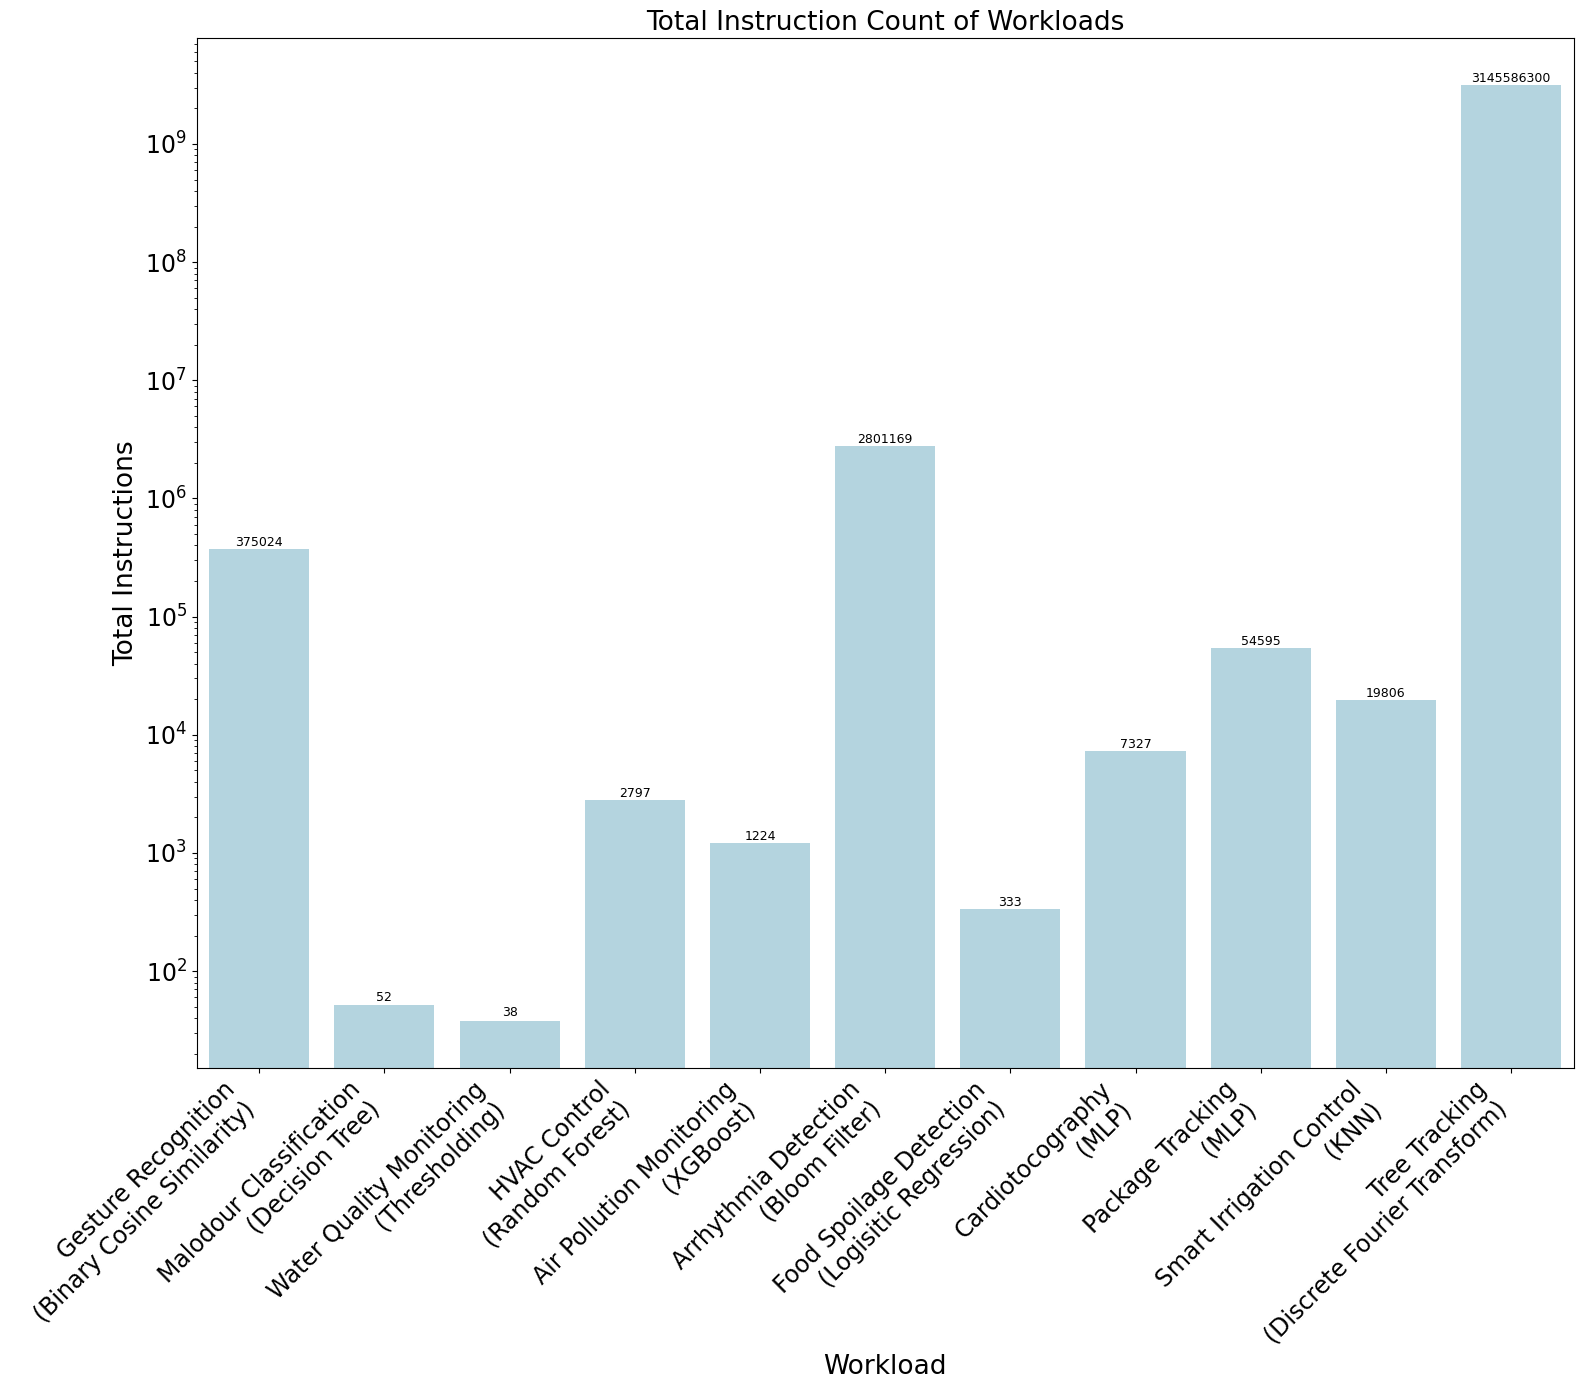

In [13]:
# 2. Plot total instructions (log scale)
def plot_total_instructions(total_instructions_data):
    sorted_workloads = list(instruction_data.keys())
    total_instructions = [total_instructions_data[workload] for workload in sorted_workloads]
    data = {
        "Workload": sorted_workloads,
        "Total Instructions": total_instructions
    }
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.barplot(
        x="Workload",
        y="Total Instructions",
        data=data,
        color='#add8e6',
        ax=ax
    )
    ax.set_xlabel('Workload')
    ax.set_ylabel('Total Instructions')
    ax.set_title('Total Instruction Count of Workloads')
    ax.set_yscale("log")
    ax.set_xticklabels(sorted_workloads, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("plots/total_instructions.pdf", dpi=300, bbox_inches='tight')
    # Optionally label bars
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        label_value = total_instructions[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f'{label_value}',
            ha='center',
            va='bottom',
            fontsize=9
        )
    plt.show()

plot_total_instructions(total_instructions_data)


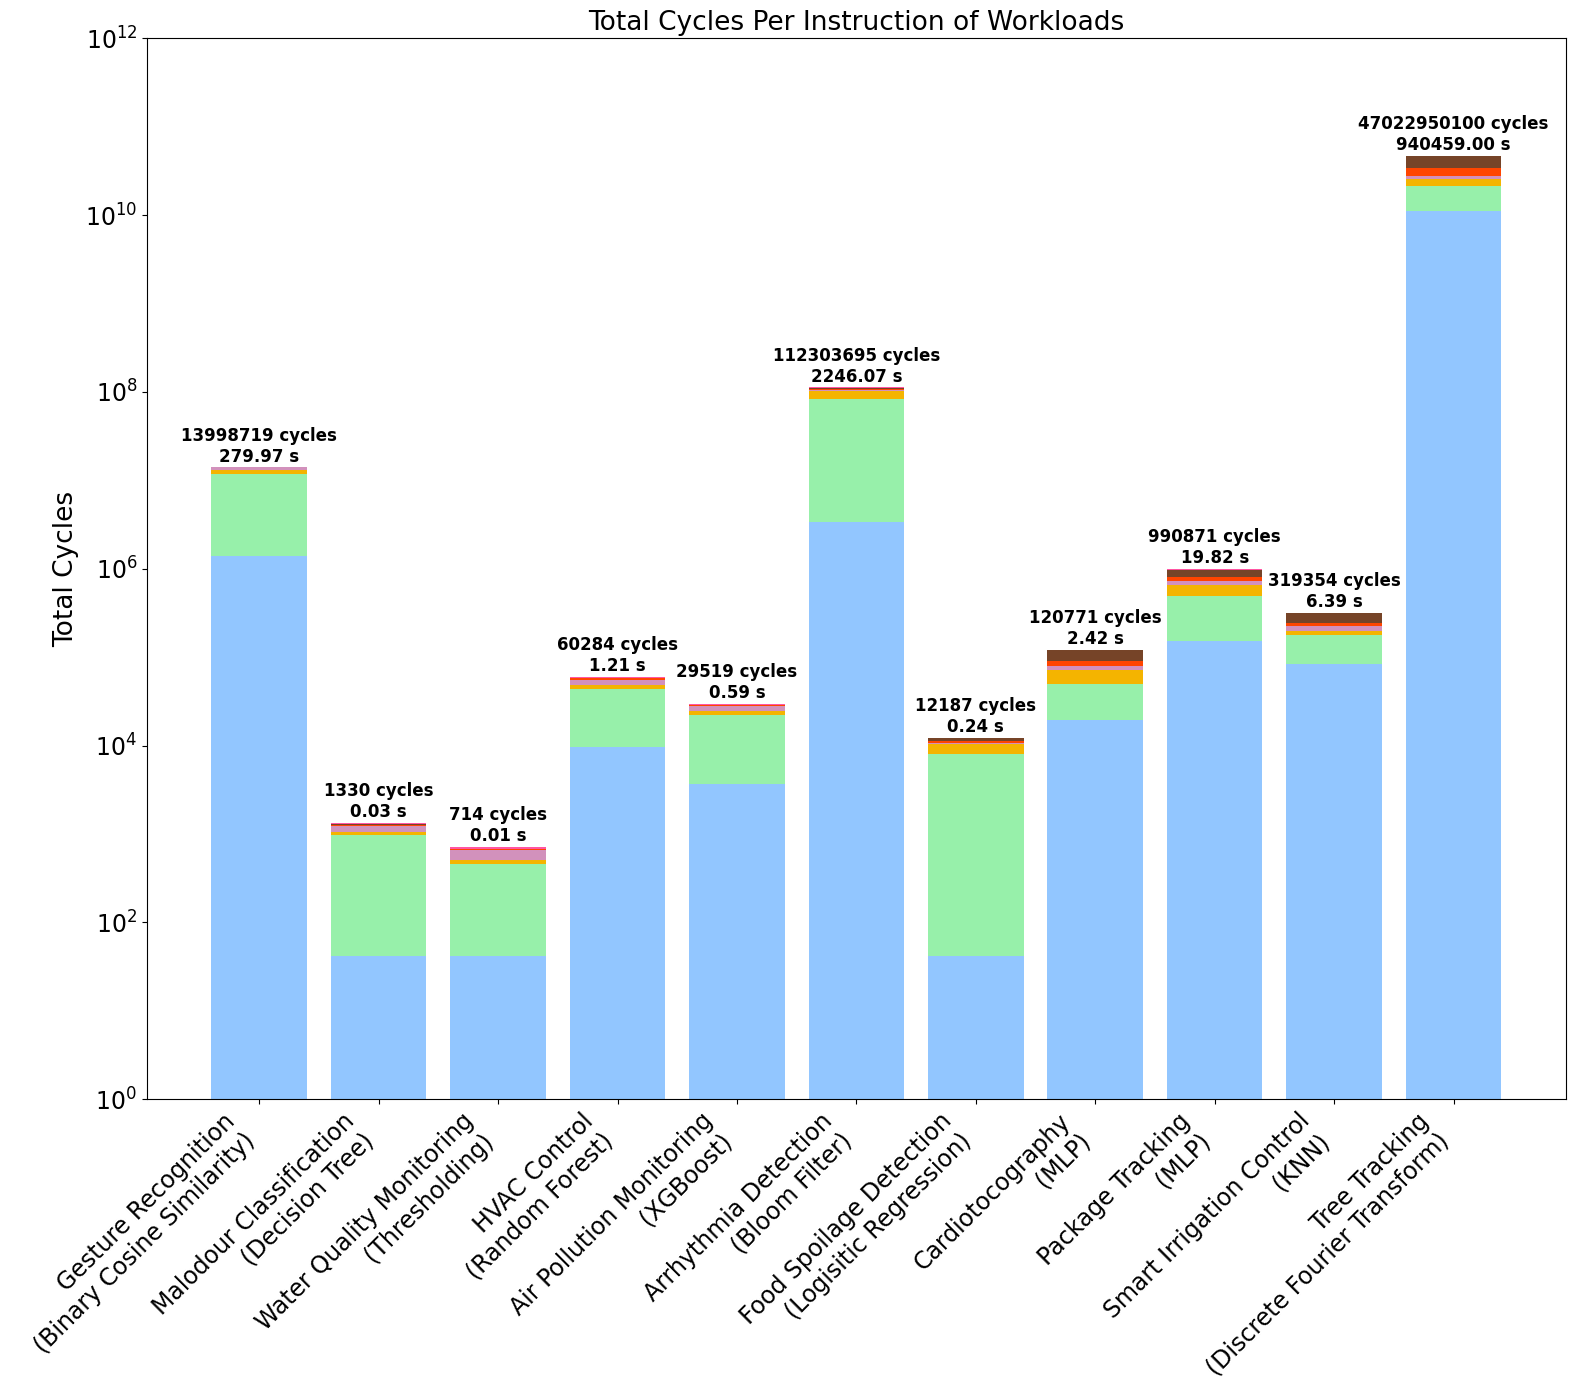

In [14]:

# 3. Plot total cycles per instruction (stacked bar, log scale) using seaborn
def plot_total_cycles_per_instruction(instruction_data, total_instructions_data, log_scale=True, clock_freq=50000):
    sorted_workloads = list(instruction_data.keys())
    records = []
    total_cycles_per_workload = {}
    for workload in sorted_workloads:
        total_cycles = 0
        for category in CATEGORIES:
            count = instruction_data[workload][category]
            cycles = count * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][category]
            records.append({
                "Workload": workload,
                "Category": category,
                "Cycles": cycles
            })
            total_cycles += cycles
        total_cycles_per_workload[workload] = total_cycles

    df = pd.DataFrame(records)
    # Pivot for stacked bar
    df_pivot = df.pivot(index="Workload", columns="Category", values="Cycles").fillna(0)
    df_pivot = df_pivot.loc[sorted_workloads]  # Ensure order

    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(16, 14))
    bottom = None
    for idx, (category, color) in enumerate(zip(CATEGORIES, CATEGORY_COLORS)):
        values = df_pivot[category].values
        bars = ax.bar(df_pivot.index, values, label=category, color=color, bottom=bottom)
        if bottom is None:
            bottom = values
        else:
            bottom = bottom + values

    # Annotate with total cycles and runtime
    for i, workload in enumerate(sorted_workloads):
        total_cycles = total_cycles_per_workload[workload]
        runtime_seconds = total_cycles / clock_freq
        ax.text(i, total_cycles + 0.05 * total_cycles, f'{total_cycles:.0f} cycles\n{runtime_seconds:.2f} s', 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    if log_scale:
        ax.set_yscale('log')
    ax.set_ylabel('Total Cycles')
    ax.set_title('Total Cycles Per Instruction of Workloads')
    ax.set_ylim(1, 1e12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("plots/total_cycles_per_instruction.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_total_cycles_per_instruction(instruction_data, total_instructions_data)


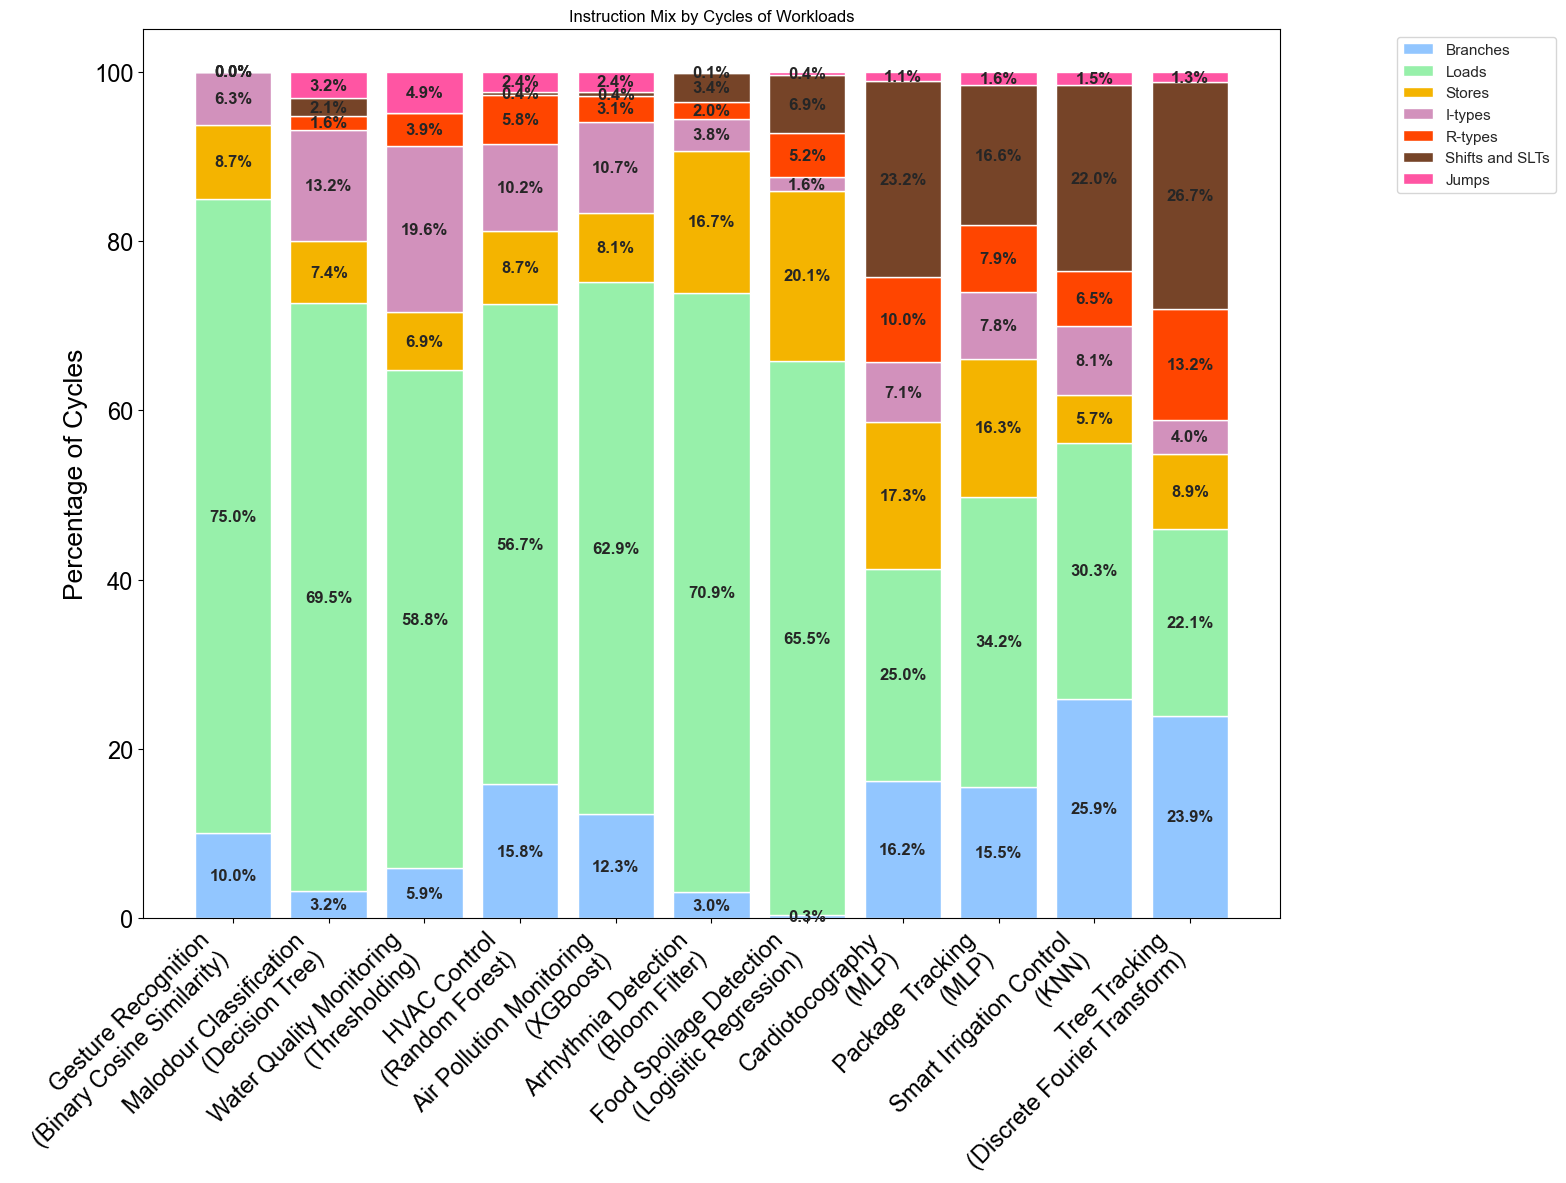

In [15]:
# 4. Plot instruction mix by cycles (percent of cycles per category) using seaborn
def plot_instruction_mix_by_cycles(instruction_data, total_instructions_data):    # Build DataFrame for seaborn
    records = []
    sorted_workloads = list(instruction_data.keys())

    for workload in sorted_workloads:
        total_cycles = sum(
            instruction_data[workload][cat] * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][cat]
            for cat in CATEGORIES
        )
        for category in CATEGORIES:
            cycles = instruction_data[workload][category] * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][category]
            percent = (cycles / total_cycles * 100) if total_cycles != 0 else 0
            records.append({
                "Workload": workload,
                "Category": category,
                "Percent": percent
            })
    df = pd.DataFrame(records)
    # Set category order for consistent coloring
    df["Category"] = pd.Categorical(df["Category"], categories=CATEGORIES, ordered=True)
    # Set color palette
    palette = {cat: color for cat, color in zip(CATEGORIES, CATEGORY_COLORS)}
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_theme(style="whitegrid")
    # Stacked barplot
    bottom = None
    for idx, category in enumerate(CATEGORIES):
        data = df[df["Category"] == category]
        values = data["Percent"].values
        if bottom is None:
            bars = ax.bar(sorted_workloads, values, label=category, color=palette[category])
            bottom = values
        else:
            bars = ax.bar(sorted_workloads, values, label=category, color=palette[category], bottom=bottom)
            bottom = bottom + values
        # Annotate bars
        for bar, value in zip(bars, values):
            if value > 0:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{value:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=12,
                    fontweight='bold'
                )
    ax.set_ylabel('Percentage of Cycles')
    ax.set_title('Instruction Mix by Cycles of Workloads')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    ax.set_ylim(0, 105)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("plots/instruction_mix_by_cycles.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_instruction_mix_by_cycles(instruction_data, total_instructions_data)


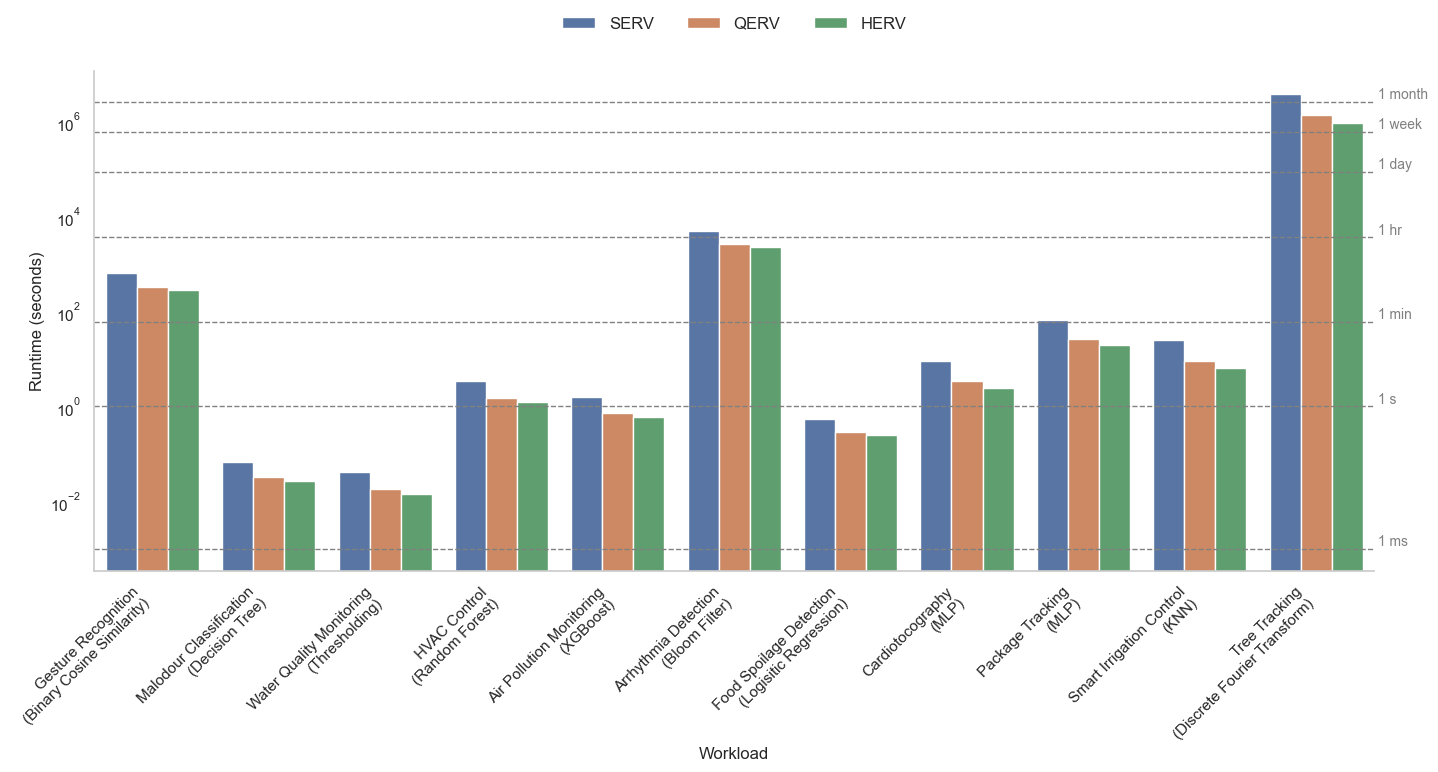

In [16]:

# 5. Plot runtime per core (SERV, QERV, HERV) using seaborn
def plot_runtime_per_core(instruction_data, clock_freq=50000, log_scale=True):
    sorted_workloads = list(instruction_data.keys())
    cores = ["SERV", "QERV", "HERV"]
    records = []
    for workload in sorted_workloads:
        for i, core in enumerate(cores):
            total_cycles = 0
            for category in CYCLES_PER_INSTRUCTION_BY_CORE[core]:
                count = instruction_data[workload].get(category, 0)
                cycles = CYCLES_PER_INSTRUCTION_BY_CORE[core][category]
                total_cycles += count * cycles
            runtime_seconds = total_cycles / clock_freq
            records.append({
                "Workload": clean_workload_name(workload),
                "Core": core,
                "Runtime (seconds)": runtime_seconds
            })
    df = pd.DataFrame(records)

    plt.figure(figsize=(16, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(
        data=df,
        x="Workload",
        y="Runtime (seconds)",
        hue="Core",
        palette=CORE_COLORS[:len(cores)],
        dodge=True
    )
    ax.set_ylabel("Runtime (seconds)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if log_scale:
        ax.set_yscale('log')
    plt.xticks(rotation=45, ha='right')
    for label, value in DUTY_CYCLE_THRESHOLDS.items():
        ax.axhline(y=value, linestyle='--', color='gray', linewidth=1)
        ax.text(len(sorted_workloads)-0.5, value, f" {label}", va='bottom', ha='left', color='gray', fontsize=10)
    ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=3,
        frameon=False,
        fontsize=12
    )
    ax.grid(axis='y', linestyle='', alpha=0.6)
    plt.subplots_adjust(
        top=0.9,
        bottom=0.40,
        left=0.15,
        right=0.95
    )
    plt.savefig("plots/flexibits_runtime_comparison.pdf", dpi=300)
    plt.show()

plot_runtime_per_core(instruction_data)
